## __Plato Notebook 1: Example workflow__

Thomas Schouten

This jupyter notebook provides a walkthrough of the features of the Plato algorithm used to calculate theoretical velocity increases resulting from sediment subduction.

#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the model string identifier "Muller2016", which automatically downloads the relevant files from the GPlately DataServer.

In [2]:
# Set parameters
TEST_RUN = True

# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
if TEST_RUN:
    ages = [0, 50]
else:
    ages = np.arange(0, 51, 1)

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "01-Example_workflow"))

data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "01-Example_workflow"))

# Set up PlateTorques object
M2016 = PlateTorques(reconstruction_name = reconstruction_name, ages = ages, files_dir=results_dir)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Calculating RMS velocities: 100%|██████████| 2/2 [00:00<00:00, 17084.74it/s]


#### __2. Sampling and torque calculation__

The below cell calls the `sample_all` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

Then, the cell calls the `calculate_all_torques` method of the `PlateTorques` object to calculate all torques.

In [3]:
# Sample seafloor ages
M2016.sample_seafloor_ages()

# Calculate torques
M2016.calculate_all_torques()

Calculating residual forces at points: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


#### __3. Saving__

The below cell saves the `PlateTorques` object 

In [4]:
# Save results to folder
M2016.save_all()

Saving Globe: 100%|██████████| 1/1 [00:00<00:00, 224.78it/s]


#### __4. Data extraction__

The below cells extract the magnitude RMS velocity and the residual torque for the the Pacific Plate for the ages of interest and plot these.

#### __5. Optimisation__

The below cells instantiate an `Optimisation` object and uses it to find the combination of slab pull constant and mantle viscosity that minimises the residual torque normalised by the driving torque for the Cocos, Nazca and Pacific plates in the present-day using the function `minimise_residual_torque`. The normalised residual torques of each individual plate are weighted by its area.

In [5]:
optimise_M2016 = Optimisation(M2016)

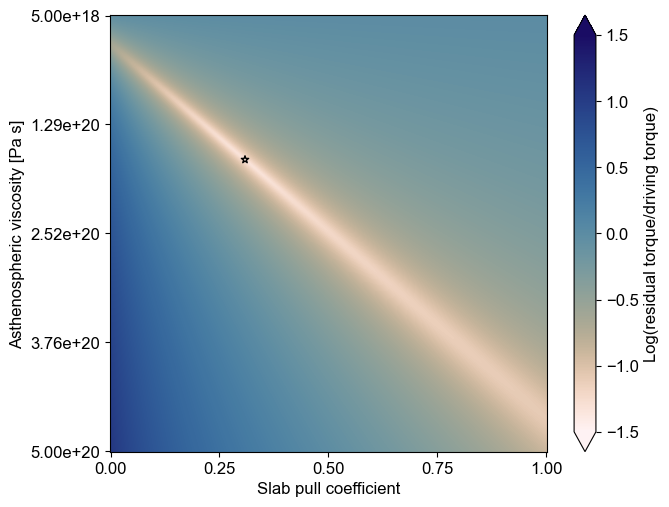

Optimal coefficients for  Pacific, Cocos, Nazca  plate(s), (PlateIDs:  901.0, 909.0, 911.0 )
Minimum residual torque: 4.69% of driving torque
Optimum asthenospheric viscosity [Pa s]: 1.69e+20
Optimum drag coefficient [Pa s/m]: 8.43e+14
Optimum slab pull coefficient: 30.86%


In [6]:
_, optimal_parameters, _ = optimise_M2016.minimise_residual_torque(ages = 0, plateIDs = [901, 909, 911], plot = True, savefig = os.path.join(figs_dir, "M2016_optimisation.png"))

In [7]:
# Apply parameters
optimise_M2016.apply_parameters(optimal_parameters[0])

Calculating residual forces at points: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [8]:
# Extract data of interest
rms_speed = M2016.extract_data_through_time(var = "velocity_rms_mag", plateIDs=[101, 201, 901, 911])
rms_spin_rate = M2016.extract_data_through_time(var = "spin_rate_rms_mag", plateIDs=[101, 201, 901, 911])
mean_azimuth = M2016.extract_data_through_time(var = "velocity_mean_azi", plateIDs=[101, 201, 901, 911])
residual_torque = M2016.extract_data_through_time(var = "residual_torque_mag", plateIDs=[101, 201, 901, 911])
driving_torque = M2016.extract_data_through_time(var = "driving_torque_mag", plateIDs=[101, 201, 901, 911])

#### __6. Plotting__

The below cells plot the reconstructed seafloor age and velocity distribution for the Müller et al. (2016) reconstruction.

In [9]:
# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10.5*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 18
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

In [10]:
M2016_plot = PlotReconstruction(M2016)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Warning 1: /Users/thomas/Library/Caches/gplately/Muller2016.unzip/Muller_etal_2016_AREPS_Supplement_v1.17/Shapefiles/Coastlines/Global_coastlines_2015_v1_low_res.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.


No continents in Muller2016.


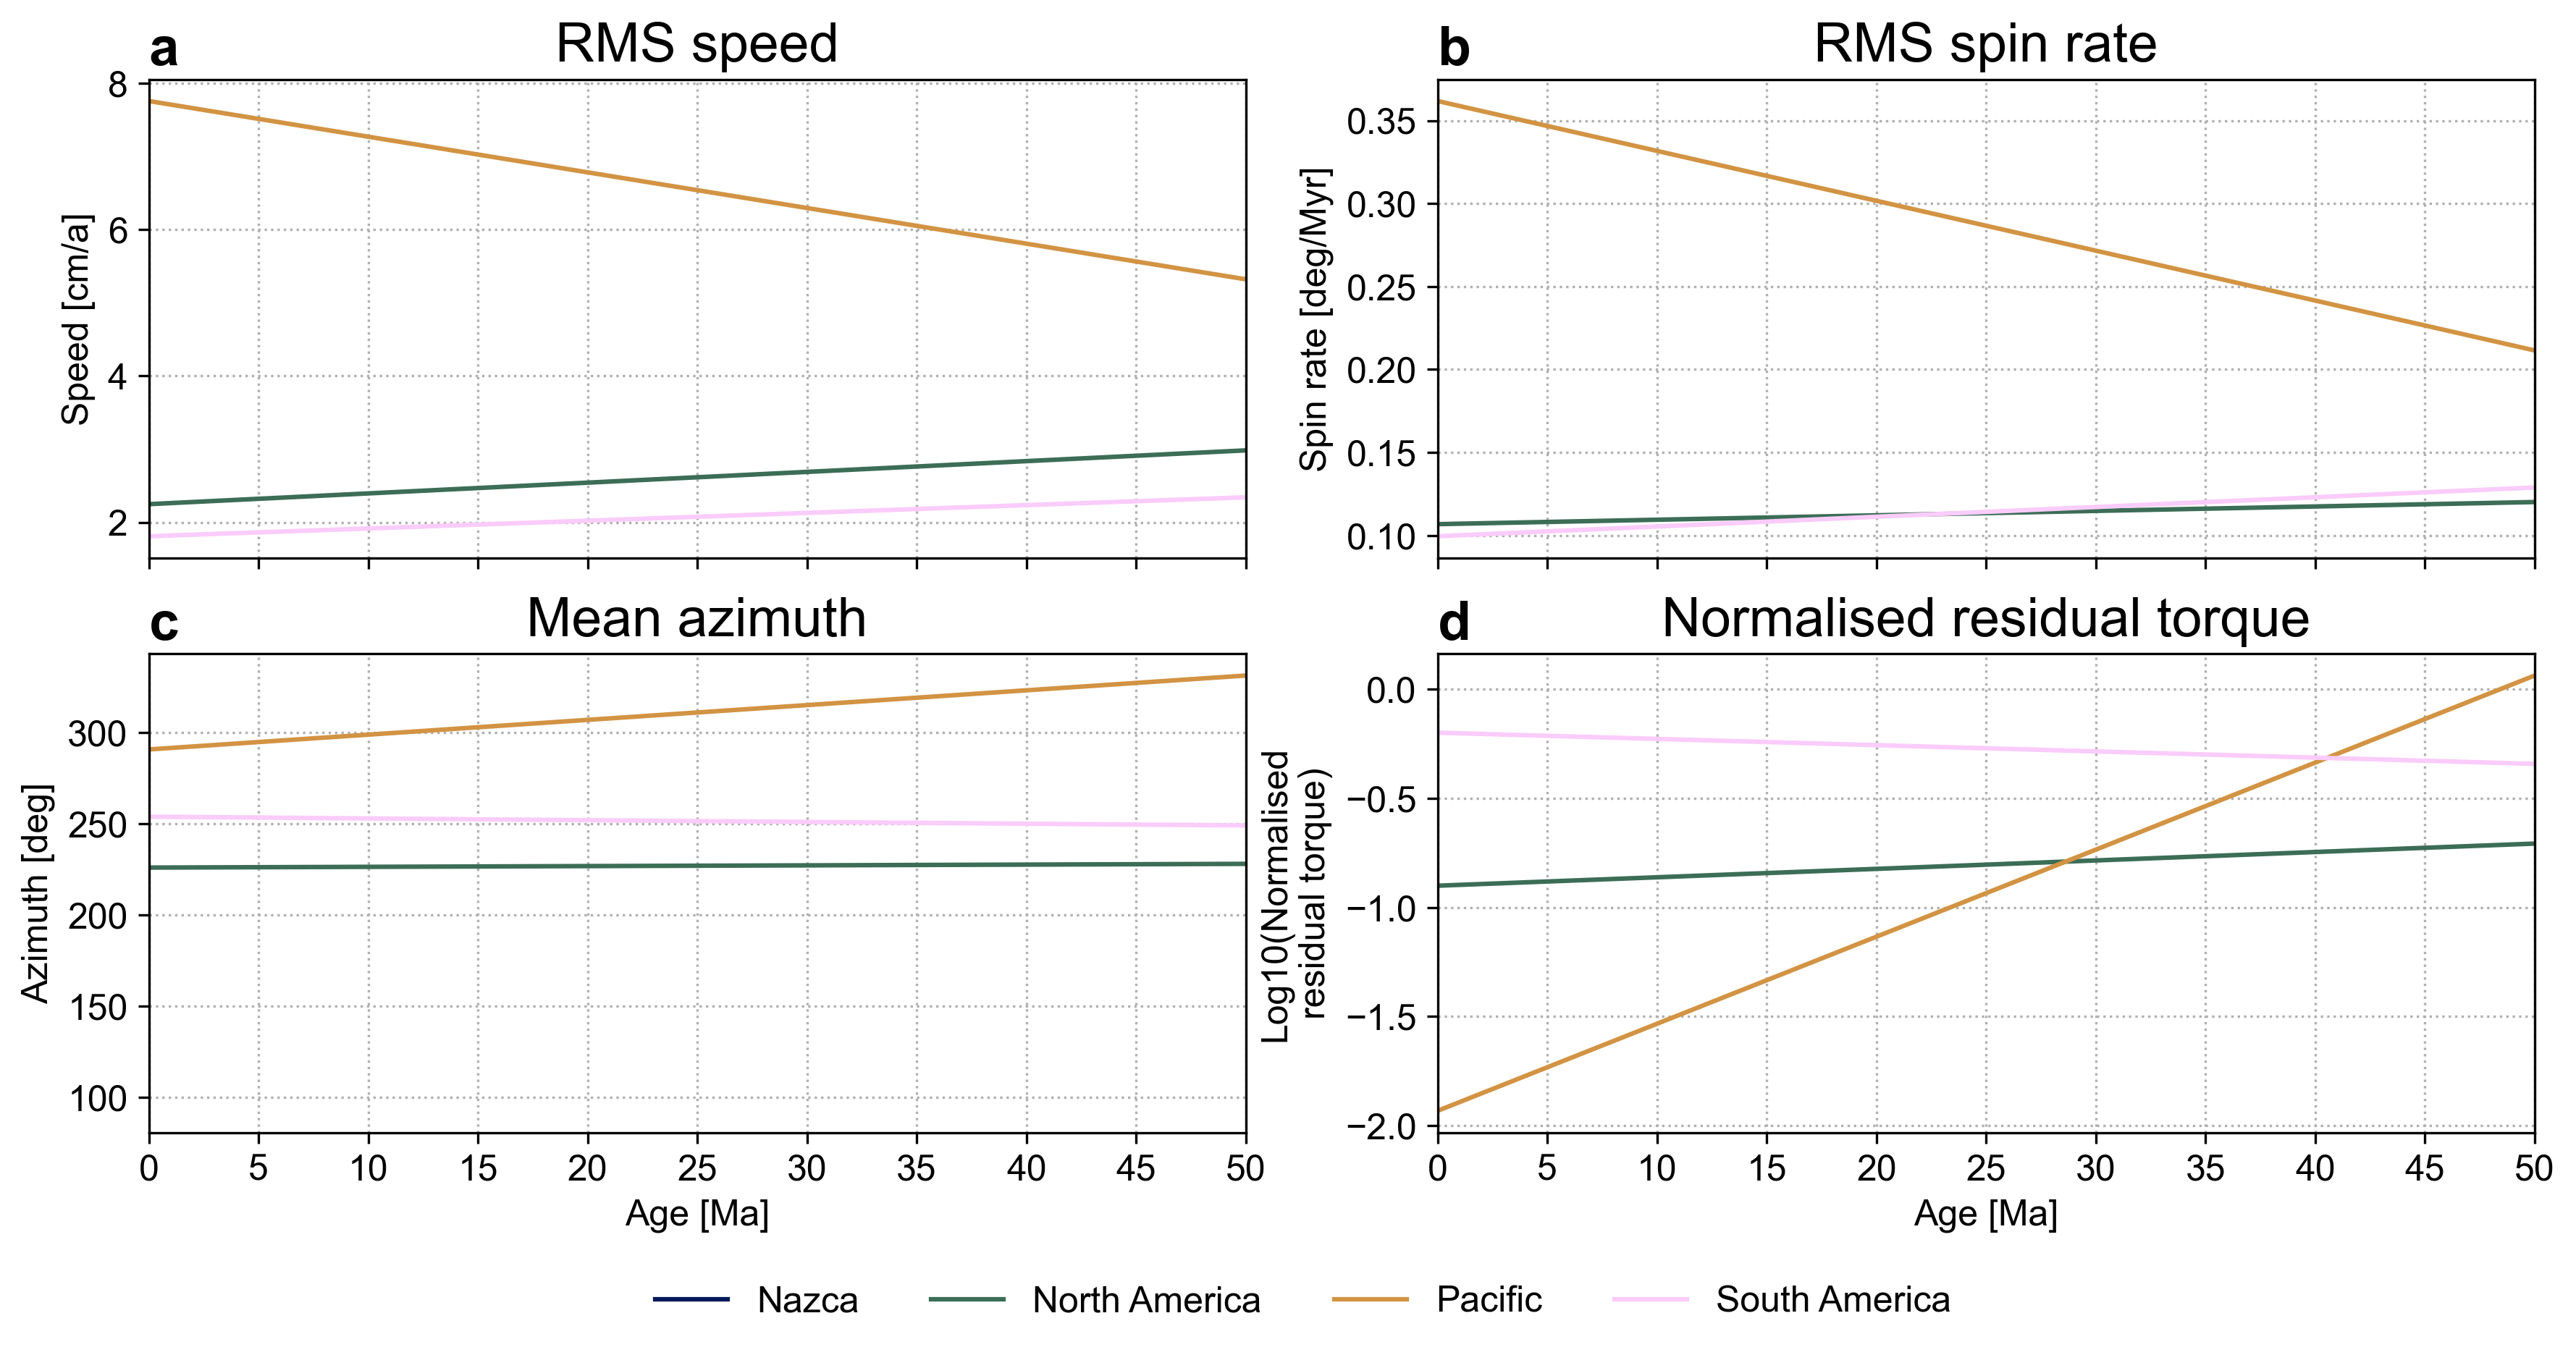

In [11]:
# Create a figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.175, hspace=0.2)

plot_plateIDs = [911, 101, 901, 201]
plot_plate_names = ["Nazca", "North America", "Pacific", "South America"]
plot_metrics = [rms_speed, rms_spin_rate, mean_azimuth, residual_torque, driving_torque]
plot_metric_names = ["RMS speed", "RMS spin rate", "Mean azimuth", "Normalised residual torque"]
plot_ylabels = ["Speed [cm/a]", "Spin rate [deg/Myr]", "Azimuth [deg]", "Log10(Normalised\nresidual torque)"]
plot_ylims = [(0, 10), (0, 0.6), (0, 360), (-2.5, 1)]
plot_colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, len(plot_plateIDs)))

m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        ax.set_title(plot_metric_names[m], fontsize=title_fontsize)
        for k, plateID in enumerate(plot_plateIDs):
            ax.plot(
                plot_metrics[m]["Age"],
                np.log10(plot_metrics[m][plot_plateIDs[k]]/plot_metrics[m+1][plot_plateIDs[k]]) if m ==3 else plot_metrics[m][plot_plateIDs[k]], 
                label = plot_plate_names[k],
                color = plot_colours[k]
            )

        ax.grid(ls=":")
        
        ax.set_xlim(plot_metrics[m]["Age"].min(), plot_metrics[m]["Age"].max())
        ax.set_xticks(np.arange(plot_metrics[m]["Age"].min(), plot_metrics[m]["Age"].max()+1, 5))
        ax.set_xticklabels([]) if i == 0 else None
        ax.set_xlabel("Age [Ma]") if i == 1 else None

        ax.set_ylabel(plot_ylabels[m])
        # ax.set_ylim(plot_ylims[m])

        ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)

        m += 1

# Add a legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.05))

fig.savefig(os.path.join(figs_dir, "M2016_metrics.png"), bbox_inches="tight")

plt.show()

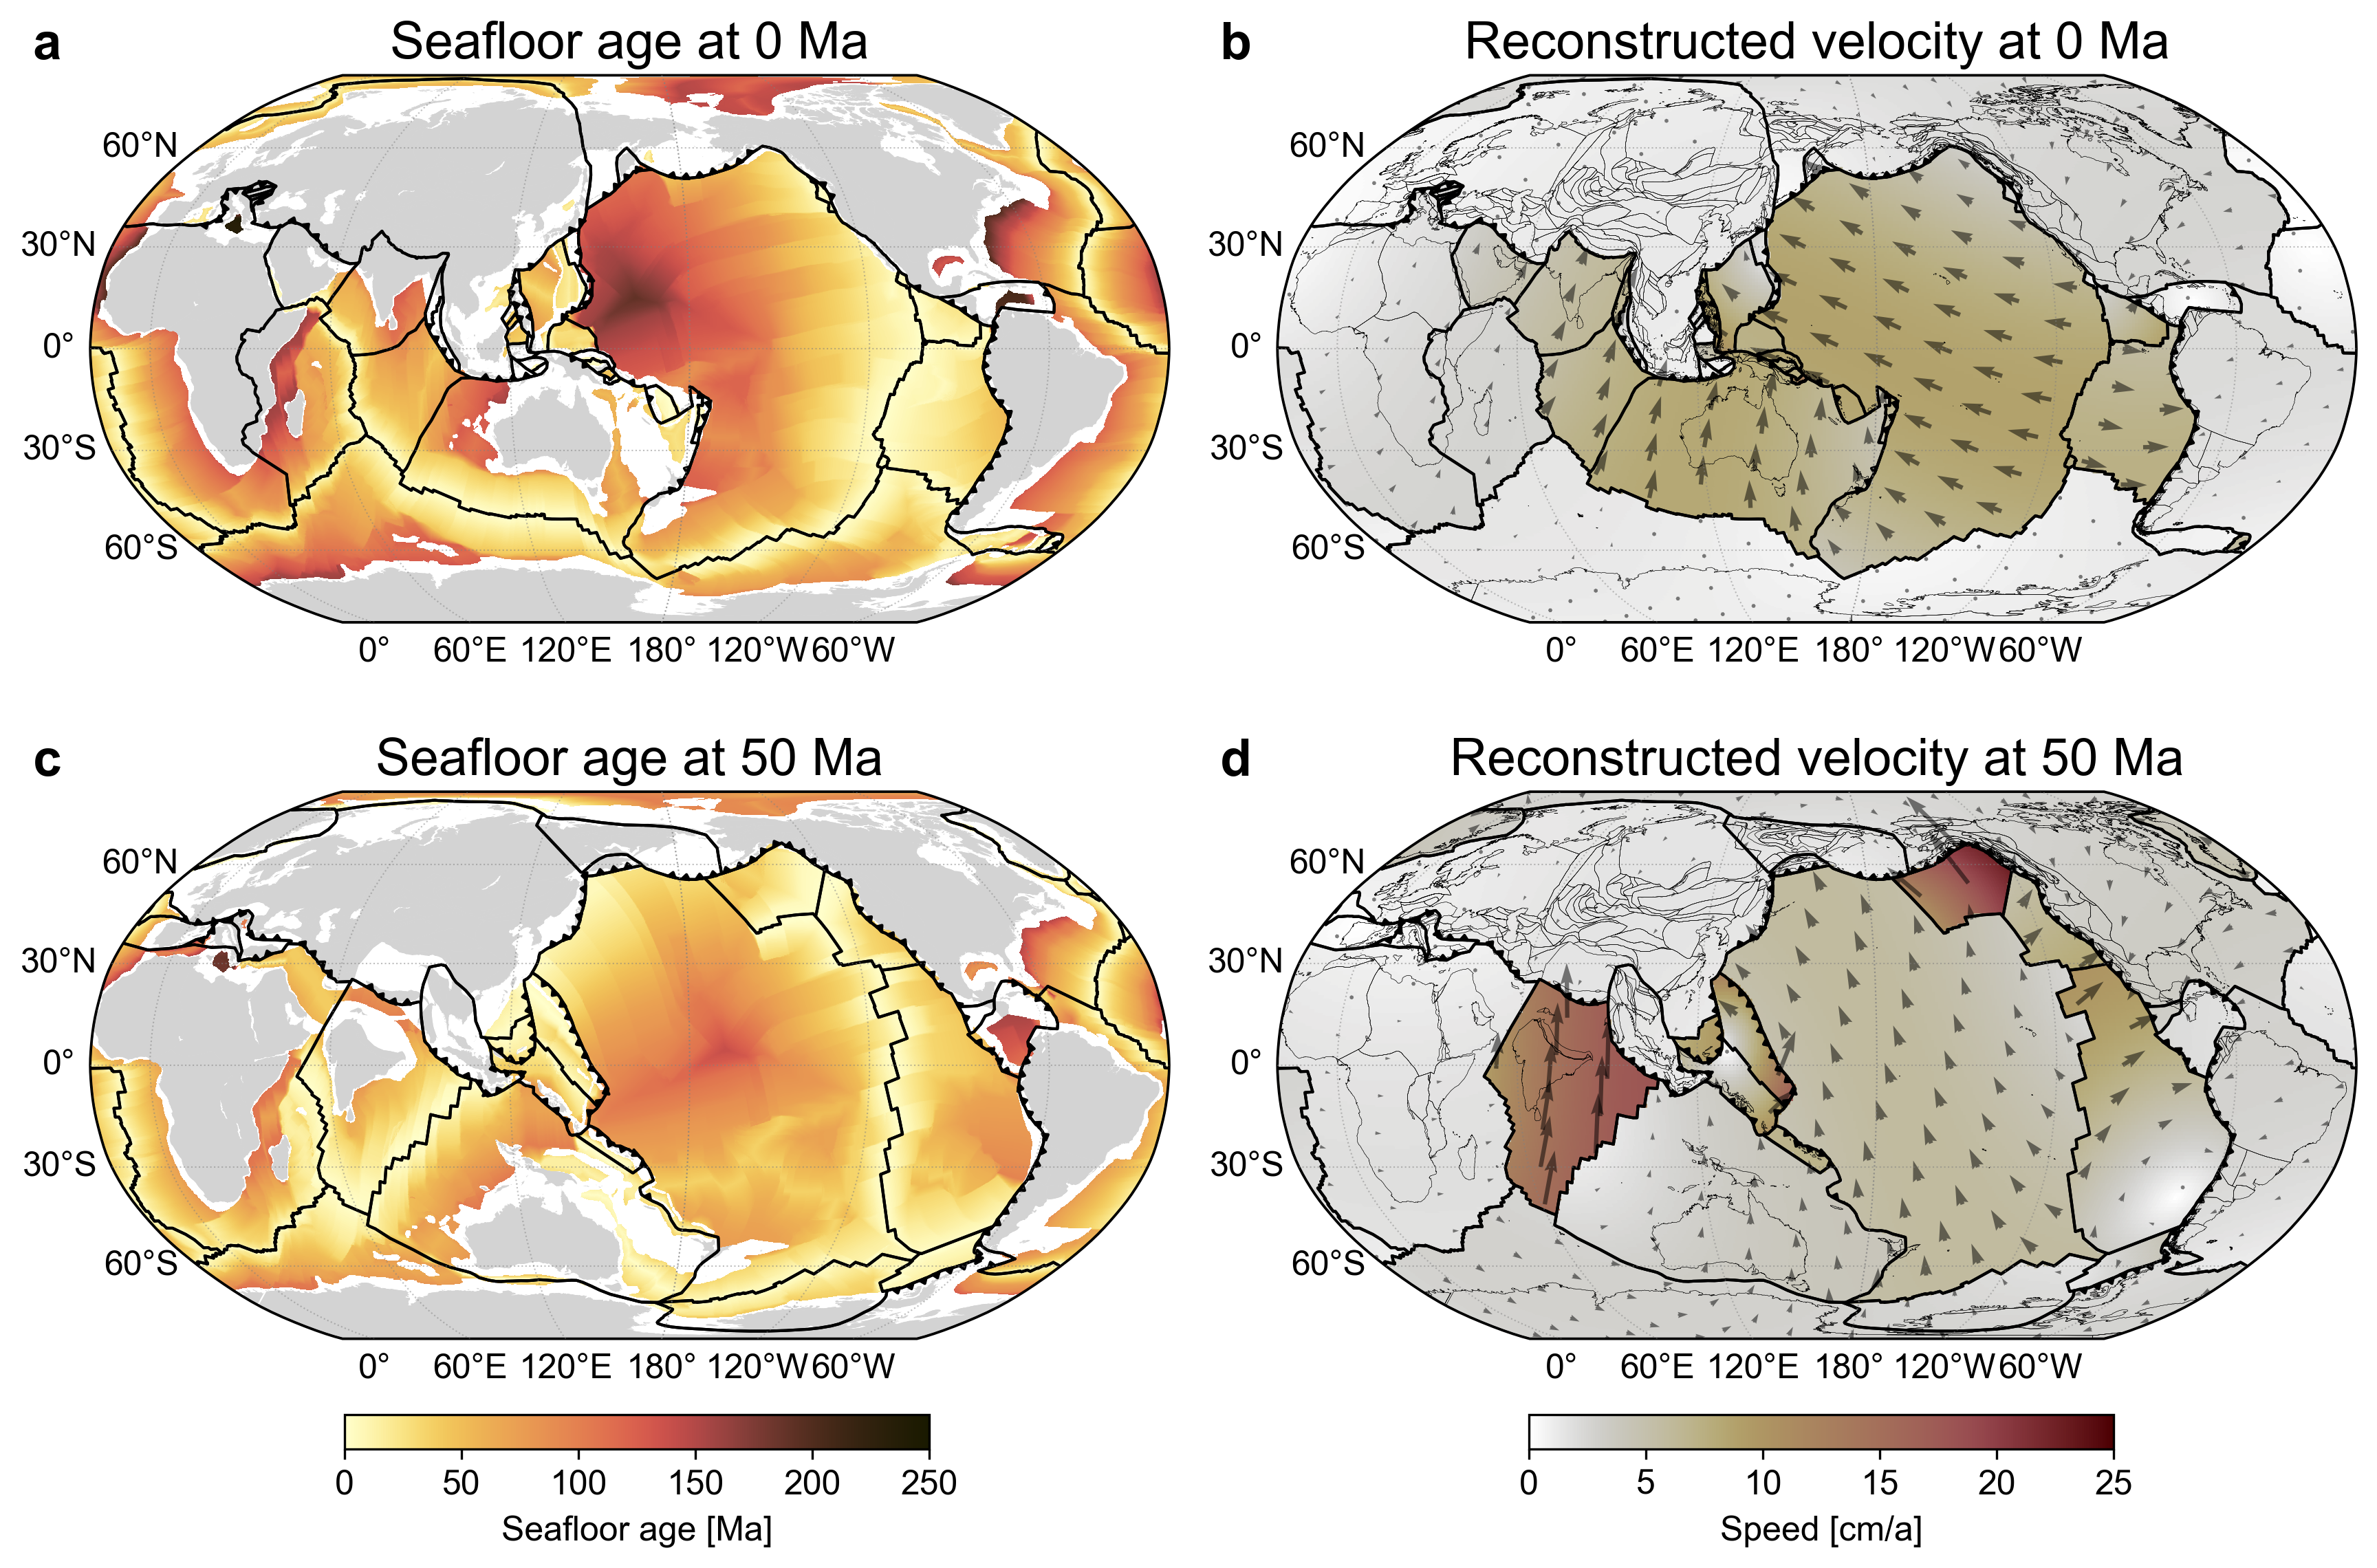

In [12]:
fig = plt.figure(figsize=(fig_width, fig_height_maps), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], wspace=0.1)

k = 0
for i in range(0, 2):
    for j in range(0, 2):
        ax = plt.subplot(gs[i, j], projection=projection)
        age = 0 if i == 0 else 50
        if j == 0:
            seafloor_ages = M2016_plot.plot_seafloor_age_map(ax, age=age)
            ax.set_title(f"Seafloor age at {age} Ma", fontsize=title_fontsize)
        else:
            speeds, velocities = M2016_plot.plot_velocity_map(ax, age=age)
            ax.set_title(f"Reconstructed velocity at {age} Ma", fontsize=title_fontsize)
        ax.annotate(annotations[k], xy=(-0.053, 1.03), xycoords="axes fraction", fontsize=title_fontsize, fontweight="bold")
        k += 1

# Create new grids for the colourbars
cax1 = fig.add_axes([0.212, 0.06, 0.2, 0.02])
cax2 = fig.add_axes([0.617, 0.06, 0.2, 0.02])

# Create a colorbar below the subplots
cbar1 = plt.colorbar(seafloor_ages, cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(speeds, cax=cax2, orientation="horizontal")

# Set colorbar label
cbar1.set_label("Seafloor age [Ma]", labelpad=5)
cbar2.set_label("Speed [cm/a]", labelpad=5)

fig.savefig(os.path.join(figs_dir, "M2016_maps.png"), bbox_inches="tight")
plt.show()